In [1]:
!pip install --root-user-action ignore pygraphviz

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for pygraphviz: filename=pygraphviz-1.14-cp312-cp312-linux_x86_64.whl size=203284 sha256=5f872fd2ea916363f7eb64d0efb1a802d3abe5c3967eb585685430b27b359d82
  Stored in directory: /root/.cache/pip/wheels/e1/2f/c3/0f7719eda975973b474b79b98e1208e635565c1e4dac777ac8
Successfully built pygraphviz


In [2]:
from langchain_openai import ChatOpenAI
from langchain.prompts import PromptTemplate
from langchain.chains import LLMChain
from langchain.utilities import SQLDatabase
from langchain_experimental.sql import SQLDatabaseChain
from langgraph.graph import StateGraph, END
from neo4j import GraphDatabase
from typing import TypedDict, List, Dict, Optional
import os
import json

# === 設定 ===
# .envファイルから接続情報をロード
from dotenv import load_dotenv
import openai
load_dotenv(dotenv_path=".env")
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY", "your_openai_api_key")
openai.api_key = OPENAI_API_KEY
OPENAI_MODEL = "gpt-4.1-nano"
NEO4J_URI = os.getenv("NEO4J_URI")
NEO4J_USER = os.getenv("NEO4J_USER")
NEO4J_PASSWORD = os.getenv("NEO4J_PASSWORD")
POSTGRES_HOST = os.getenv("POSTGRES_HOST", "localhost")
POSTGRES_PORT = os.getenv("POSTGRES_PORT", "5432")
POSTGRES_DB   = os.getenv("POSTGRES_DB", "legal_db")
POSTGRES_USER = os.getenv("POSTGRES_USER", "postgres")
POSTGRES_PASSWORD = os.getenv("POSTGRES_PASSWORD", "password")
POSTGRES_URI = f"postgresql+psycopg2://{POSTGRES_USER}:{POSTGRES_PASSWORD}@{POSTGRES_HOST}:{POSTGRES_PORT}/{POSTGRES_DB}"

llm = ChatOpenAI(model=OPENAI_MODEL, temperature=0, openai_api_key=OPENAI_API_KEY)

In [3]:
from sqlalchemy import create_engine, MetaData, Table, Column, String, Boolean, text
from sqlalchemy.exc import SQLAlchemyError
import os
from dotenv import load_dotenv

load_dotenv()  # .envファイルから環境変数をロード

# POSTGRES_URIが環境変数に設定されていない場合は以下で構築
POSTGRES_URI = os.getenv("POSTGRES_URI")
if not POSTGRES_URI:
    POSTGRES_URI = f"postgresql+psycopg2://{os.getenv('POSTGRES_USER', 'postgres')}:" \
                   f"{os.getenv('POSTGRES_PASSWORD', 'password')}@" \
                   f"{os.getenv('POSTGRES_HOST', 'localhost')}:" \
                   f"{os.getenv('POSTGRES_PORT', '5432')}/" \
                   f"{os.getenv('POSTGRES_DB', 'legal_db')}"

# DBエンジン作成
engine = create_engine(POSTGRES_URI)
metadata = MetaData()

# 新しいテーブル定義
substances = Table(
    'substances', metadata,
    Column('name', String, nullable=False),
    Column('cas_no', String, nullable=False),
    Column('ec_no', String, nullable=False),
    Column('is_svhc', Boolean, nullable=False),
    Column('is_authorized', Boolean, nullable=False),
    Column('is_restricted', Boolean, nullable=False),
)

# テーブルが存在する場合は削除
metadata.drop_all(engine)

with engine.connect() as conn:
    try:
        # 新しいテーブルを作成
        metadata.create_all(bind=engine)
        print("新しいテーブル 'substances' を作成しました。")
        
        # ダミーデータの挿入
        subs = [
            {
                "name": "formaldehyde",
                "cas_no": "50-00-0",
                "ec_no": "200-001-8",
                "is_svhc": True,
                "is_authorized": False,
                "is_restricted": False
            },
            {
                "name": "Trichloroethylene",
                "cas_no": "79-01-6",
                "ec_no": "200-002-8",
                "is_svhc": False,
                "is_authorized": True,
                "is_restricted": False
            },
            {
                "name": "Chloroethene",
                "cas_no": "75-07-0",
                "ec_no": "200-003-4",
                "is_svhc": False,
                "is_authorized": False,
                "is_restricted": True
            }
        ]
        query = "INSERT INTO substances (name, cas_no, ec_no, is_svhc, is_authorized, is_restricted) VALUES (:name, :cas_no, :ec_no, :is_svhc, :is_authorized, :is_restricted)"
        for sub in subs:
            result = conn.execute(text(query), sub)
        conn.commit()
        print("ダミーデータを挿入しました。")

        select_query = "SELECT * FROM substances"
        result_set = conn.execute(text(select_query)).fetchall()
        for row in result_set:
            print(row)
    except SQLAlchemyError as e:
        print("エラー:", e)

新しいテーブル 'substances' を作成しました。
ダミーデータを挿入しました。
('formaldehyde', '50-00-0', '200-001-8', True, False, False)
('Trichloroethylene', '79-01-6', '200-002-8', False, True, False)
('Chloroethene', '75-07-0', '200-003-4', False, False, True)


In [ ]:
from neo4j import GraphDatabase
class ReachKnowledgeInserter:

    def __init__(self, uri, user, password):
        self.driver = GraphDatabase.driver(uri, auth=(user, password))

    def close(self):
        self.driver.close()

    def insert_knowledge(self):
        with self.driver.session() as session:
            session.write_transaction(self._insert_reach_knowledge)

    @staticmethod
    def _insert_reach_knowledge(tx):
        # 初期化
        tx.run("""
            MATCH (n)
            DETACH DELETE n
        """)
        # SDS 提出義務
        tx.run("""
            MERGE (sds:Obligation {name: "SDS_Submission"})
            MERGE (ref1:LegalReference {article: "31", regulation: "REACH"})
            MERGE (sds)-[:REFERENCE]->(ref1)
            MERGE (note1:Note {text: "一定の危険有害性を有する物質にはSDSの提出義務がある。"})
            MERGE (sds)-[:DESCRIPTION]->(note1)
        """)

        # 登録義務（1t以上）
        tx.run("""
            MERGE (registration:Obligation {name: "Registration"})
            MERGE (import:Actor {name: "Importer"})
            MERGE (OR:Actor {name: "Only Representative"})
            MERGE (import)-[:MUST_PERFORM]->(registration)
            MERGE (OR)-[:MUST_PERFORM]->(registration)
            MERGE (ref_5:LegalReference {article: "5", regulation: "REACH"})
            MERGE (ref_6:LegalReference {article: "6", regulation: "REACH"})
            MERGE (registration)-[:REFERENCE]->(ref_5)
            MERGE (registration)-[:REFERENCE]->(ref_6)
            MERGE (note2:Note {text: "EU域内で1t以上の化学物質を輸入する場合は登録義務がある。"})
            MERGE (import)-[:DESCRIPTION]->(note2)
            MERGE (OR)-[:DESCRIPTION]->(note2)
            MERGE (sds:Obligation {name: "SDS_Submission"})
            MERGE (import)-[:REQUESTS]->(sds)
            MERGE (OR)-[:REQUESTS]->(sds)
        """)

        # トン数に応じた試験
        tx.run("""
            MERGE (registration:Obligation {name: "Registration"})
            MERGE (test_1:Requirement {threshold: 1, unit: "ton", action: "トン数帯に応じた試験の実施"})
            MERGE (test_10:Requirement {threshold: 10, unit: "ton", action: "トン数帯に応じた試験の実施"})
            MERGE (test_100:Requirement {threshold: 100, unit: "ton", action: "トン数帯に応じた試験の実施"})
            MERGE (test_1000:Requirement {threshold: 1000, unit: "ton", action: "トン数帯に応じた試験の実施"})
            MERGE (registration)-[:REQUESTS]->(test_1)
            MERGE (registration)-[:REQUESTS]->(test_10)
            MERGE (registration)-[:REQUESTS]->(test_100)
            MERGE (registration)-[:REQUESTS]->(test_1000)
            MERGE (ref_a6:LegalReference {article: "Annex VI", regulation: "REACH"})
            MERGE (ref_a7:LegalReference {article: "Annex VII", regulation: "REACH"})
            MERGE (ref_a8:LegalReference {article: "Annex VIII", regulation: "REACH"})
            MERGE (ref_a9:LegalReference {article: "Annex IX", regulation: "REACH"})
            MERGE (ref_a10:LegalReference {article: "Annex X", regulation: "REACH"})
            MERGE (test_1)-[:REFERENCE]->(ref_a7)
            MERGE (test_10)-[:REFERENCE]->(ref_a7)
            MERGE (test_10)-[:REFERENCE]->(ref_a8)
            MERGE (test_100)-[:REFERENCE]->(ref_a7)
            MERGE (test_100)-[:REFERENCE]->(ref_a8)
            MERGE (test_100)-[:REFERENCE]->(ref_a9)
            MERGE (test_100)-[:REFERENCE]->(ref_a7)
            MERGE (test_100)-[:REFERENCE]->(ref_a8)
            MERGE (test_100)-[:REFERENCE]->(ref_a9)
            MERGE (test_1000)-[:REFERENCE]->(ref_a7)
            MERGE (test_1000)-[:REFERENCE]->(ref_a8)
            MERGE (test_1000)-[:REFERENCE]->(ref_a9)
            MERGE (test_1000)-[:REFERENCE]->(ref_a10)
        """)

        # 安全性評価および通知
        tx.run("""
            MERGE (import:Actor {name: "Importer"})
            MERGE (OR:Actor {name: "Only Representative"})
            MERGE (assessment:Obligation {name: "Chemical Safety Assessment"})
            MERGE (notification:Obligation {name: "Substance Notification"})
            MERGE (import)-[:MUST_PERFORM]->(assessment)
            MERGE (import)-[:MUST_PERFORM]->(notification)
            MERGE (OR)-[:MUST_PERFORM]->(assessment)
            MERGE (OR)-[:MUST_PERFORM]->(notification)
            MERGE (ref6:LegalReference {article: "14", regulation: "REACH"})
            MERGE (ref7:LegalReference {article: "38", regulation: "REACH"})
            MERGE (assessment)-[:REFERENCE]->(ref6)
            MERGE (notification)-[:REFERENCE]->(ref7)
        """)

        # SVHC関連
        tx.run("""
            MERGE (substance:Substance {name: "Example Substance"})
            MERGE (svhc:ListStatus {name: "SVHC"})
            MERGE (svhcHandling:Obligation {name: "SVHC Notification"})
            MERGE (substance)-[:LISTED_IN]->(svhc)
            MERGE (svhc)-[:TRIGGERS]->(svhcHandling)
            MERGE (ref57:LegalReference {article: "57", regulation: "REACH"})
            MERGE (ref58:LegalReference {article: "58", regulation: "REACH"})
            MERGE (ref59:LegalReference {article: "59", regulation: "REACH"})
            MERGE (svhcHandling)-[:REFERENCE]->(ref57)
            MERGE (svhcHandling)-[:REFERENCE]->(ref58)
            MERGE (svhcHandling)-[:REFERENCE]->(ref59)
        """)

        # Authorisation List
        tx.run("""
            MERGE (substance:Substance {name: "Example Substance"})
            MERGE (authorised:ListStatus {name: "Authorisation List"})
            MERGE (authorisation:Obligation {name: "Apply for Authorisation"})
            MERGE (substance)-[:LISTED_IN]->(authorised)
            MERGE (authorised)-[:REQUIRES]->(authorisation)
            MERGE (ref9:LegalReference {article: "56", regulation: "REACH"})
            MERGE (authorisation)-[:REFERENCE]->(ref9)
        """)

        # Restriction List
        tx.run("""
            MERGE (substance:Substance {name: "Example Substance"})
            MERGE (restricted:ListStatus {name: "Restriction List"})
            MERGE (restrictionHandling:Obligation {name: "Comply with Restriction"})
            MERGE (substance)-[:LISTED_IN]->(restricted)
            MERGE (restricted)-[:REQUIRES]->(restrictionHandling)
            MERGE (ref10:LegalReference {article: "67", regulation: "REACH"})
            MERGE (restrictionHandling)-[:REFERENCE]->(ref10)
        """)


# 実行
if __name__ == "__main__":
    inserter = ReachKnowledgeInserter(NEO4J_URI, NEO4J_USER, NEO4J_PASSWORD)
    inserter.insert_knowledge()
    inserter.close()
    print("REACHナレッジベースをNeo4jに挿入しました。")

# http://localhost:7474/browser/preview/
# 
# MATCH (n)-[r]->(m) RETURN n, r, m


/tmp/ipykernel_858/3176266331.py:12: DeprecationWarning: write_transaction has been renamed to execute_write
  session.write_transaction(self._insert_reach_knowledge)


REACHナレッジベースをNeo4jに挿入しました。


In [ ]:
# === ステップ 1: Router ===

## 理由を述べさせないと回答不能による傾向がある
router_prompt = PromptTemplate.from_template("""
あなたはREACH規則CLP規則に関するチャットボットで、専門家が編纂した法規制関連のDBを保持しています。
以下の質問に対して、DBからの情報を提供可能か、判断してください。
質問: {question}
理由を述べてから、「対応不能」または「DBとして回答可能」、「欧州化学品規制に関係しない」で回答してください。
""")
router_chain = LLMChain(llm=llm, prompt=router_prompt)

# === ステップ 2: EntityExtractor ===
entity_prompt = PromptTemplate.from_template("""
次の質問は化学物質に関する規制に関するものです。対象物質を抽出してください。また、規制課題に関連する質問者が関心のある箇所を英語で抜き出してください。規制課題には物質の固有名を入れないでください。規制課題はリスト形式で出力してください。
質問: {question} 
答え: 以下のようにJSON形式で出力してください。
{{
  "substance": [
    {{
      "name": "formaldehyde",
      "cas_no": "50-00-0",
      "ec_no": "200-001-8"
    }},
  ],
  "regulation": {{
    "question": [
        ""
    ]
  }}
}}
""")
entity_chain = LLMChain(llm=llm, prompt=entity_prompt)
def extract_entities(state):
    state["retry"] += 1
    print("[質問]:", state["question"])
    question = state["question"]
    result = entity_chain.run({"question": question})
    print("[Entity抽出結果]:", result)
    state["extracted"] = json.loads(result)
    return {"extracted": json.loads(result)}

# === ステップ 3: Cypher生成用プロンプト（高度版） ===
cypher_prompt = PromptTemplate.from_template("""
あなたは法規制データベースにアクセスするプロフェッショナルなAIです。
クライアントの質問に関連するLegalReferenceを取得する、Neo4jで利用するCypherクエリを生成してください。
回答はCypherクエリのみにしてください。

【質問】:
{question}

グラフスキーマ:
- (actor)-[:MUST_PERFORM]->(obligation)-[:REFERENCE]->(LegalReference)

Nodeの例:
(:ListStatus {{name: "SVHC"}})
(:Note {{text: "EU域内で1t以上の化学物質を輸入する場合は登録義務がある。"}})
(:Obligation {{name: "Chemical Safety Assessment"}})
(:Obligation {{name: "SDS_Submission"}})
(:Obligation {{name: "Substance Notification"}})
(:Obligation {{name: "SVHC Notification"}})
(:Requirement {{action: "トン数帯に応じた試験の実施", unit: "ton", threshold: 1}})
(:Substance {{name: "Example Substance"}})
(:actor {{name: "only representative"}})

【Cypherクエリ】:
""")
cypher_chain = LLMChain(llm=llm, prompt=cypher_prompt)

# === ステップ 4: Graph Search（Neo4j） ===
def graph_search(state):
    questions = state["extracted"]["regulation"]["question"]
    
    print("[質問]:", questions)
    cypher_queries = [cypher_chain.run({"question": i}) for i in questions]
    print("[Cypherクエリ]:", cypher_queries)

    driver = GraphDatabase.driver(NEO4J_URI, auth=(NEO4J_USER, NEO4J_PASSWORD))
    finalrecords = []
    for cypher_query in cypher_queries:
        with driver.session() as session:
            results = session.run(cypher_query)
            records = [dict(r) for r in results]
            finalrecords += [i["legalRef"]["regulation"] + "第" + i["legalRef"] ["article"] +"条" for i in records]
        
    print("[Neo4j結果]:", finalrecords)
    
    return {
        "cypher": cypher_queries,
        "graph_results": finalrecords
    }

# === ステップ 5: RDB検索（PostgreSQL） ===
from sqlalchemy import create_engine, text, Table, Column, String, Boolean, MetaData
from sqlalchemy.orm import sessionmaker

metadata = MetaData()
db = SQLDatabase.from_uri(POSTGRES_URI)
sql_chain = SQLDatabaseChain.from_llm(llm, db, verbose=True)

substances = Table(
    'substances', metadata,
    Column('name', String, nullable=False),
    Column('cas_no', String, nullable=False),
    Column('ec_no', String, nullable=False),
    Column('is_svhc', Boolean, nullable=False),
    Column('is_authorized', Boolean, nullable=False),
    Column('is_restricted', Boolean, nullable=False),
)
engine = create_engine(POSTGRES_URI)
def substance_info_filler(state):
    state["substance"] = []
    # SQLクエリを構築
    query = "SELECT * FROM substances WHERE "
    for entity in state["extracted"]["substance"]:
        print("[Entity情報]:", entity)
        substance_name = entity["name"]
        cas_no = entity["cas_no"]
        ec_no = entity["ec_no"]
        if not substance_name and not cas_no and not ec_no: 
            continue
        conditions = []
        params = {}
        if substance_name in state["question"]:
            conditions.append("name = :substance_name")
            params["substance_name"] = substance_name
        if cas_no in state["question"]:
            conditions.append("cas_no = :cas_no")
            params["cas_no"] = cas_no
        if ec_no in state["question"]:
            conditions.append("ec_no = :ec_no")
            params["ec_no"] = ec_no
        query += " AND ".join(conditions)

        print("[PostgreSQLクエリ]:", query)
        print("[クエリパラメータ]:", params)

        # データベースクエリを実行
        with engine.connect() as connection:
            session = sessionmaker(bind=connection)()
            result = session.execute(text(query), params).fetchall()
            print("[PostgreSQL結果]:", result)
            if result:
                state["substance"].append({
                    "name": result[0][0],
                    "cas_no": result[0][1],
                    "ec_no": result[0][2],
                    "is_svhc": result[0][3],
                    "is_authorized": result[0][4],
                    "is_restricted": result[0][5]
                })
            else:
                state["substance_info"] = "該当する物質情報が見つかりませんでした"
            session.close()

            
# === ステップ 6: Grader（評価） ===
grade_prompt = PromptTemplate.from_template("""
質問: {question}
回答: {answer}
→ この回答中の条文はどれくらい適切か？ 0.0〜1.0 で出力せよ
""")
grade_chain = LLMChain(llm=llm, prompt=grade_prompt)

def grade(state):
    q = state["question"]
    g = state.get("graph_results", [])
    g_text = "\n".join(str(r) for r in g)
    s_info = state.get("substance_info", "")
    answer = g_text + "\n\n" + s_info
    print("[合成回答]:", answer)
    score = grade_chain.run({"question": q, "answer": answer})
    print("[満足度スコア]:", score)
    return {"final_answer": answer, "score": score}

# === 実行関数 ===
class QAState(TypedDict, total=False):
    question: str
    technical_terms: Optional[str]
    router_output: Optional[str]
    extracted: Dict
    cypher: Optional[str]
    graph_results: Optional[str]
    substance: Optional[List[Dict[str, str]]]
    substance_info: Optional[str]
    regulation: Optional[List[str]]
    final_answer: Optional[str]
    score: str
    retry: int

def route_based_on_output(state: QAState) -> str:
    output = state.get("router_output")
    if output and "欧州化学品規制に関係しない" in output:
        print(output)
        state["final_answer"] = "関係のない質問はご遠慮ください"
        return "not_related"
    if output and "対応不能" in output:
        print(output)
        state["final_answer"] = "当社コンサルタントにご相談ください"
        return "ask_us"
    else:
        print(output)
        state["retry"] = 3
        return "perform_as_consultant"

builder = StateGraph(state_schema=QAState)
builder.add_node("router", lambda s: {"router_output": router_chain.run(s["question"]), "retry": 0})
builder.add_node("extractor", extract_entities) #lambda s: {"extracted": entity_chain.run(s["question"])})
builder.add_node("ask_us", lambda s: {"final_answer": "当社コンサルタントにご相談ください"})
builder.add_node("not_related", lambda s: {"final_answer": "関係のない質問はご遠慮ください"})
builder.add_node("graph_search", graph_search)
builder.add_node("substance_info_filler", substance_info_filler)
builder.add_node("grader", grade)
        
builder.set_entry_point("router")
builder.add_conditional_edges("router", route_based_on_output, {"ask_us": "ask_us", "not_related": "not_related", "perform_as_consultant": "extractor"})
builder.add_edge("extractor", "substance_info_filler")
builder.add_edge("substance_info_filler", "graph_search")
builder.add_edge("graph_search", "grader")
def route_to_grader(state: QAState) -> str: 
    if state["retry"] == 3 : return "END"
    return "under0.8" if float(state["score"]) < 0.8 else "END"
builder.add_conditional_edges("grader", route_to_grader, {"under0.8": "extractor", "END": END})

graph = builder.compile()


/tmp/ipykernel_858/2695725832.py:10: LangChainDeprecationWarning: The class `LLMChain` was deprecated in LangChain 0.1.17 and will be removed in 1.0. Use :meth:`~RunnableSequence, e.g., `prompt | llm`` instead.
  router_chain = LLMChain(llm=llm, prompt=router_prompt)


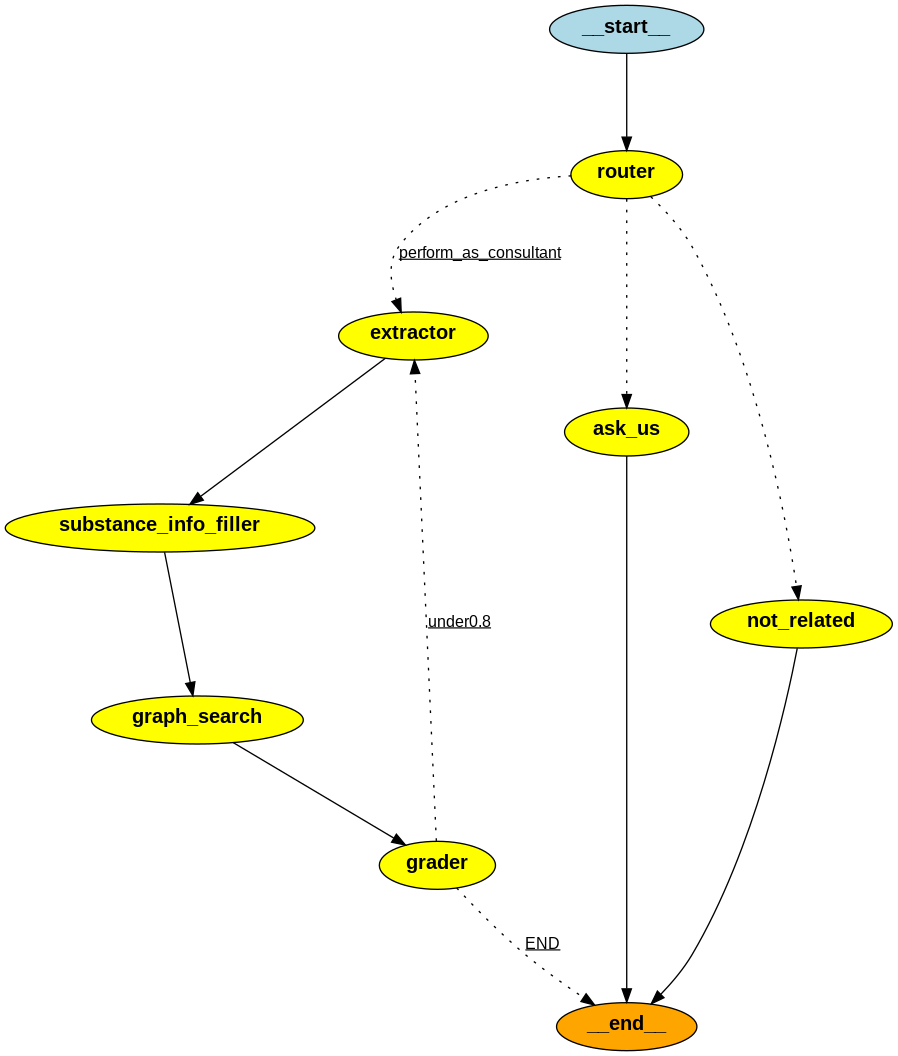

In [ ]:
from IPython.display import Image
Image(graph.get_graph().draw_png())

In [ ]:
question = "明日の夕食は何にしますか？"

result = graph.invoke({"question": question})
print(result)

In [ ]:
question = "私たちは50-00-0を含む製品をEUに輸入する予定ですが、SDSの提出義務はありますか？"

result = graph.invoke({"question": question})
print(result)

In [ ]:
question = "私たちは欧州にformaldehydeを含む製品をEUに輸入する予定ですが、何をすればよいですか？"

result = graph.invoke({"question": question})
print(result)

In [ ]:
question = "REACH規則の今後の変更について教えてください。"
result = graph.invoke({"question": question})
print(result)

In [ ]:
NEO4J_USER